In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Colab/Datasets/AirQual
!echo "--------"
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab/Datasets/AirQual
--------
all_measurements.csv


In [54]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import json
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import math
import sys, time, os
from IPython.display import clear_output
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import time
from scipy.interpolate import LinearNDInterpolator
from functools import lru_cache
from datetime import datetime

import tensorflow.keras as keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.losses import MeanSquaredError


In [5]:
dataset_path = 'all_measurements.csv'
predict_columns = ["PM10"]
cracow_center = 50.061868834110356, 19.937604241982864
cracow_center_radius = 4 #km
center_latlong2km_conversion = (111.11, 71.43)
test_valid_ratio = 4

SEED = 123;

# csv columns:
LATITUDE = 'latitude'
LONGITUDE = 'longitude'
ELEVATION = 'elevation'
SENSOR_ID = 'sensorId'
FROM_DATE_TIME = 'fromDateTime'
TILL_DATE_TIME = 'tillDateTime'
PM1 = 'PM1'
PM25 = 'PM25'
PM10 = 'PM10'
PRESSURE = 'pressure'
HUMIDITY = 'humidity'
TEMP = 'temperature'
WIND_SPEED = 'wind_speed'
WIND_BEARING = 'wind_bearing'
# additional df columns:
DATE = 'date'
HOUR = 'hour'
WEEKDAY = 'weekday'
WIND_BEARING_RAD = 'wind_bearing_rad'
RHO = 'rho'
THETA = 'theta'
X_COLUMN = 'x'
Y_COLUMN = 'y'


all_data = pd.read_csv('all_measurements.csv')
all_data[FROM_DATE_TIME] = all_data[FROM_DATE_TIME].map(pd.to_datetime)
all_data[TILL_DATE_TIME] = all_data[TILL_DATE_TIME].map(pd.to_datetime)


In [6]:
#=================
#   DATA UTILS
#=================

def polar2xy(r,theta):
  if type(r) != np.ndarray or type(theta) != np.ndarray:
    r, theta = np.array(r), np.array(theta)
  assert r.shape == theta.shape

  dir = np.exp( 1j * theta )
  return r * np.real(dir), r * np.imag(dir)

def xy2polar(x,y):
  if type(x) != np.ndarray or type(y) != np.ndarray:
    x, y = np.array(x), np.array(y)
  assert x.shape == y.shape

  x = x.astype(np.csingle)
  y = y.astype(np.csingle)
  return  np.abs(x+y*(1j)).astype(np.double), ((np.angle(x+y*(1j))) % (2*math.pi)).astype(np.double)

def latlong2xy(lat, longi, c_lat, c_longi): #-> (km, km)
  y = (lat-c_lat)*center_latlong2km_conversion[0]
  x = (longi-c_longi)*center_latlong2km_conversion[1]
  return (x,y)

def xy2latlong(x, y, c_lat, c_longi):
  lat = (y/center_latlong2km_conversion[0]) + c_lat
  longi = (x/(center_latlong2km_conversion[1])) + c_longi
  return (lat,longi)

def latlong2polar(lat, longi, c_lat, c_longi): #-> (km, rad)
  return xy2polar(*latlong2xy(lat, longi, c_lat, c_longi))

# rho: km, theta: rad
def polar2latlong(rho, theta, c_lat, c_longi):
  return xy2latlong(*polar2xy(rho, theta),c_lat, c_longi)

#tests
in1 = 14, 22, 14,22
out1 = latlong2polar(*in1)
assert np.isclose(out1[0], 0) and np.isclose(out1[1], 0)

in2 = 12, 20, 12.1, 19.9
tmp2 = latlong2polar(*in2)
out2 = polar2latlong(tmp2[0], tmp2[1], in2[2], in2[3])
assert np.isclose(out2[0], in2[0]) and np.isclose(out2[1], in2[1])

in3 = np.array([14,12]), np.array([22,20]), np.array([14,12.1]), np.array([22,19.9])
tmp3 = latlong2polar(*in3)
out3 = polar2latlong(tmp3[0], tmp3[1], in3[2], in3[3])
assert np.all(np.isclose(out3[0], in3[0])) and np.all(np.isclose(out3[1], in3[1]))

out4 = xy2polar(-1,-1)
assert np.isclose(out4[0], math.sqrt(2)) and np.isclose(out4[1], math.pi*(1.25))

In [7]:
#drop nan
all_data = all_data[pd.notna(all_data[WIND_BEARING])]       
all_data = all_data[pd.notna(all_data[WIND_SPEED])]
all_data = all_data[pd.notna(all_data[TEMP])]
all_data = all_data[pd.notna(all_data[HUMIDITY])]
all_data = all_data[pd.notna(all_data[PRESSURE])]
all_data = all_data[pd.notna(all_data[LONGITUDE])]
all_data = all_data[pd.notna(all_data[LATITUDE])]


#wind bearing to radians
all_data[WIND_BEARING_RAD] = (all_data[WIND_BEARING]/180.0)*math.pi
# convert angle 0 from direction [0,1](North) to [1,0](East)
all_data[WIND_BEARING_RAD] = (all_data[WIND_BEARING_RAD]+math.pi/2)%(2*math.pi)

all_data.loc[:, HOUR] = all_data[FROM_DATE_TIME].map(
    lambda x: x.hour)
all_data.loc[:, DATE] = all_data[FROM_DATE_TIME].map(
    lambda x: x.date)
all_data.loc[:, WEEKDAY] = all_data[FROM_DATE_TIME].map(
    lambda x: x.weekday())

x, y = latlong2xy(all_data[LATITUDE],all_data[LONGITUDE], cracow_center[0],cracow_center[1])
all_data[X_COLUMN] = x
all_data[Y_COLUMN] = y


In [22]:


class DatasetNetworkIterator(Sequence):
  def __init__(self, datetimes, df, target_columns, batch_size = 64, inner_radius = 2):
    self.datetimes = shuffle(datetimes, random_state = SEED)
    self.datetimes_ids = np.array([i for i in range(len(self.datetimes))])
    self.batch_size = batch_size
    self.target_columns = target_columns
    self.normalize_cols = set([ELEVATION, PRESSURE, HUMIDITY, TEMP, WIND_SPEED, HOUR])
    self.rootnorm_cols = set([PM1, PM10, PM25])
    self.outer_vector_size = 20
    self.inner_vector_size = 3
    self.target_vector_size = len(target_columns) +1

    self.norm_cols_min = dict([(colname, df[colname].min()) for colname in self.normalize_cols])
    self.norm_cols_max = dict([(colname, df[colname].max()) for colname in self.normalize_cols])

    for colname in self.rootnorm_cols:
      self.norm_cols_min[colname] = df[colname].min()
      self.norm_cols_max[colname] = df[colname].max()

    self.inner_df = df[df[X_COLUMN]*df[X_COLUMN] + df[Y_COLUMN]*df[Y_COLUMN] < inner_radius**2]
    self.outer_df = df[df[X_COLUMN]*df[X_COLUMN] + df[Y_COLUMN]*df[Y_COLUMN] >= inner_radius**2]

  def __len__(self):
      return math.ceil(len(self.datetimes) // self.batch_size)

  def on_epoch_end(self):
    self.datetimes_ids = shuffle(self.datetimes_ids, random_state = SEED)


  def __getitem__(self, idx):

    batch_start = idx*self.batch_size
    batch_end = min((idx+1)*self.batch_size, len(self.datetimes))

    outer_sensor_datavectors = []
    inner_sensor_datavectors = []
    target_sensor_datavectors = []
    for dtid in self.datetimes_ids[batch_start:batch_end]:
      outer_sensor_datavectors.append(self.get_outer_states_data(dtid))
      inner_sensor_datavectors.append(self.get_inner_states_data(dtid))
      target_sensor_datavectors.append(self.get_target_states_data(dtid))

    max_outer_samples_in_batch = max(map(lambda x: len(x), outer_sensor_datavectors))
    max_inner_samples_in_batch = max(map(lambda x: len(x), inner_sensor_datavectors))

    batch_x_outer = np.zeros((batch_end-batch_start, max_outer_samples_in_batch, self.outer_vector_size))
    batch_x_inner = np.zeros((batch_end-batch_start, max_inner_samples_in_batch, self.inner_vector_size))
    batch_x_target = np.zeros((batch_end-batch_start, max_inner_samples_in_batch, self.target_vector_size))

    for i, date_datavectors in enumerate(outer_sensor_datavectors):
      for j, datavector in enumerate(date_datavectors):
        batch_x_outer[i,j] = datavector

    for i, date_datavectors in enumerate(inner_sensor_datavectors):
      for j, datavector in enumerate(date_datavectors):
        batch_x_inner[i,j] = datavector

    for i, date_datavectors in enumerate(target_sensor_datavectors):
      for j, datavector in enumerate(date_datavectors):
        batch_x_target[i,j] = datavector

    return ([batch_x_outer,batch_x_inner], batch_x_target)

  def get_batch_sensors(self, idx):
    batch_start = idx*self.batch_size
    batch_end = min((idx+1)*self.batch_size, len(self.datetimes))

    outer_sensors = []
    for dtid in self.datetimes_ids[batch_start:batch_end]:
      outer_sensors.append(self.get_outer_states_sensors(dtid))

    return outer_sensors


  @lru_cache(maxsize=40000)
  def get_outer_states_sensors(self, datetime_id):
    records = self.get_outer_by_date(self.datetimes[datetime_id])
    sensorIds = []
    for _, record in records.iterrows():
      sensorIds.append(record[SENSOR_ID])
    return sensorIds

  @lru_cache(maxsize=40000)
  def get_outer_states_data(self, datetime_id):
    records = self.get_outer_by_date(self.datetimes[datetime_id])
    datavectors = []
    for _, record in records.iterrows():
      datavectors.append(self.outer_record_to_net(record))
    return datavectors

  @lru_cache(maxsize=40000)
  def get_inner_states_data(self, datetime_id):
    records = self.get_inner_by_date(self.datetimes[datetime_id])
    datavectors = []
    for _, record in records.iterrows():
      datavectors.append(self.inner_record_to_net(record))
    return datavectors

  @lru_cache(maxsize=40000)
  def get_target_states_data(self, datetime_id):
    records = self.get_inner_by_date(self.datetimes[datetime_id])
    datavectors = []
    for _, record in records.iterrows():
      datavectors.append(self.target_record_to_net(record))
    return datavectors

  def get_record_val(self, record, colname):
    if colname in self.normalize_cols:
      return (record[colname] - self.norm_cols_min[colname])/(self.norm_cols_max[colname] - self.norm_cols_min[colname])
    elif colname in self.rootnorm_cols:
      return tf.math.pow((record[colname] - self.norm_cols_min[colname])/(self.norm_cols_max[colname] - self.norm_cols_min[colname]),1/3)
    else:
      return record[colname]

  def get_outer_by_date(self, dt):
    return self.outer_df[self.outer_df[FROM_DATE_TIME] == dt]

  def get_inner_by_date(self, dt):
    return self.inner_df[self.inner_df[FROM_DATE_TIME] == dt]

  def outer_record_to_net(self,record):
    features = np.zeros(self.outer_vector_size)
    features[0] = 1
    features[1] = self.get_record_val(record,X_COLUMN)
    features[2] = self.get_record_val(record,Y_COLUMN)
    features[3] = self.get_record_val(record,WIND_BEARING_RAD)
    features[4] = self.get_record_val(record,WIND_SPEED)
    features[5] = self.get_record_val(record,ELEVATION)
    features[6] = self.get_record_val(record,PRESSURE)
    features[7] = self.get_record_val(record,HUMIDITY)
    features[8] = self.get_record_val(record,TEMP)
    features[9] = self.get_record_val(record,HOUR)
    features[10] = self.get_record_val(record,PM1)
    features[11] = self.get_record_val(record,PM10)
    features[12] = self.get_record_val(record,PM25)
    features[13:20] = to_categorical(self.get_record_val(record,WEEKDAY),7)

    return features
  
  def inner_record_to_net(self,record):
    features = np.zeros(self.inner_vector_size)
    features[0] = 1
    features[1] = self.get_record_val(record,X_COLUMN)
    features[2] = self.get_record_val(record,Y_COLUMN)
    return features

  def target_record_to_net(self,record):
    features = np.zeros(len(self.target_columns)+1)
    features[0] = 1
    for i, colname in enumerate(self.target_columns):
      features[i+1] = self.get_record_val(record,colname)
    return features


In [9]:
def loss_fn(y_true, y_pred):
  mask = y_true[...,0]
  sqrdiff = tf.math.pow(y_true[...,-1] - y_pred[...,-1],2)
  masked = sqrdiff*mask           

  return tf.reduce_sum(masked,axis = -1)

def dummy_loss(y_true, y_pred):
  return tf.zeros(shape=(tf.shape(y_true)[0],))


def get_net(in_outer_size,in_inner_size):

  N_DISC = 16
  N_FEAT = 32

  activation = "relu"

  input_outer = Input(shape=(None, in_outer_size))
  input_inner = Input(shape=(None, in_inner_size))
  
  outer_mask = input_outer[...,0]
  outer_mask = Dropout(0.1)(outer_mask)
  inner_mask = input_inner[...,0]
  
  inner_features = input_inner[...,1:]

  outer_features = input_outer[...,1:]
  outer_wind_x = tf.expand_dims(tf.math.cos(input_outer[...,3]),-1)
  outer_wind_y = tf.expand_dims(tf.math.sin(input_outer[...,3]),-1)
  outer_features = tf.concat([outer_features, outer_wind_x, outer_wind_y], -1)

  outer_features_grid = tf.expand_dims(outer_features, -2)
  outer_features_grid = tf.repeat(outer_features_grid, tf.shape(input_inner)[-2], axis = -2)

  inner_features_grid = tf.expand_dims(inner_features, -3)
  inner_features_grid = tf.repeat(inner_features_grid, tf.shape(input_outer)[-2], axis = -3)

  #combine every (outer sensor data)X(inner location coordinates)
  cross_grid = tf.concat([outer_features_grid, inner_features_grid], -1)

  cross_x_diff = tf.expand_dims(cross_grid[...,0] - cross_grid[..., -2], -1)
  cross_y_diff = tf.expand_dims(cross_grid[...,1] - cross_grid[..., -1], -1)

  #distance between outer sensor to inner location
  cross_diff_mod = tf.math.sqrt(cross_x_diff**2 + cross_y_diff**2)

  cross_wind_x_unit = tf.expand_dims(cross_grid[...,-4], -1)
  cross_wind_y_unit = tf.expand_dims(cross_grid[...,-3], -1)

  cross_x_diff_unit = tf.math.divide_no_nan(cross_x_diff, cross_diff_mod)
  cross_y_diff_unit = tf.math.divide_no_nan(cross_y_diff, cross_diff_mod)

  #cos of wind angle from outer sensor to inner point
  cross_wind_alignment = cross_x_diff_unit*cross_wind_x_unit + cross_y_diff_unit*cross_wind_y_unit

  #add calculated metrics to grid
  cross_grid = tf.concat([cross_grid, cross_diff_mod, cross_wind_alignment], -1)

  #discriminator, rate how important each outer sensor is for predicting values at inner point
  discriminator = Dense(N_DISC,activation = activation)(cross_grid)
  discriminator = Dense(N_DISC,activation = activation)(discriminator)
  discriminator = Dense(N_DISC,activation = activation)(discriminator)
  discriminator = Dense(N_DISC,activation = activation)(discriminator)
  discriminator = Dense(N_DISC,activation = activation)(discriminator)
  # discriminator = Dense(N_DISC,activation = activation)(discriminator)
  discriminator = Dense(1,activation = "relu")(discriminator)
  discriminator = discriminator * tf.expand_dims(tf.expand_dims(outer_mask,-1),-1)
  discriminator = discriminator * tf.expand_dims(tf.repeat(tf.expand_dims(inner_mask,1),tf.shape(input_outer)[-2], axis = 1),-1)
  ratings = Softmax(axis = 1)(discriminator)

  #learn features relevant to prediction, perform their weighted sum over outer sensors based on discriminator ratings
  features = Dense(N_FEAT,activation = activation)(cross_grid)
  features = Dense(N_FEAT,activation = activation)(features)
  features = Dense(N_FEAT,activation = activation)(features)
  features = Dense(N_FEAT,activation = activation)(features)
  features = Dense(N_FEAT,activation = activation)(features)
  # features = Dense(N_FEAT,activation = activation)(features)
  features = features * tf.repeat(ratings, tf.shape(features)[-1], axis = -1)
  sum_features = tf.math.reduce_sum(features,axis = 1)

  #generate final value predictions for each inner point
  final = Dense(N_FEAT,activation = activation)(sum_features)
  final = Dense(N_FEAT,activation = activation)(final)
  final = Dense(N_FEAT,activation = activation)(final)
  final = Dense(N_FEAT,activation = activation)(final)
  final = Dense(N_FEAT,activation = activation)(final)
  final = Dense(N_FEAT,activation = activation)(final)

  final = Dense(1,activation = 'sigmoid')(final)
  final = tf.concat([tf.expand_dims(inner_mask,axis=-1), final], axis = -1)
  final = final * tf.expand_dims(inner_mask, axis = -1)

  model = Model([input_outer,input_inner], [final,ratings])
  
  return model

model = get_net(20,3)

model.compile(optimizer = RMSprop(learning_rate=0.002), loss = [loss_fn, dummy_loss])

# model.summary()

In [10]:
class HistoryCallback(Callback):
    
  def __init__(self, history = None, epilepsy_protection = False):
    self.epilepsy_protection = epilepsy_protection
    if(history == None):
      self.history = {"loss" : [],
                      "val_loss" : []}
    else:
        self.history = history

  def on_epoch_end(self,epoch,logs = None, show_from = 0):
    print(logs)
    if "val_loss" in logs:
      self.history["val_loss"].append(logs["val_loss"])
    self.history["loss"].append(logs["loss"])
    if len(self.history["loss"]) > show_from:
      clear_output()
      plt.close('all')
      plt.figure()
      plt.plot(self.history["loss"][show_from:])
      plt.plot(self.history["val_loss"][show_from:])
      plt.legend(["loss","val_loss"])
      plt.yscale('log')
      plt.show()
      if self.epilepsy_protection:
        time.sleep(0.5)
    

In [11]:
random_inners_count = 40
ids = all_data['sensorId'].unique()

random_inners = {}
for i in range(random_inners_count):
  alpha = 2 * math.pi * np.random.rand()
  r = cracow_center_radius * math.sqrt(np.random.rand())
  x = r * math.cos(alpha)
  y = r * math.sin(alpha)
  lat, longi = xy2latlong(x, y, cracow_center[0], cracow_center[1])
  random_id = int(np.random.rand()*100000)
  while random_id in ids:
    random_id = int(np.random.rand()*100000)
  np.append(ids, random_id)
  random_inners[(x, y)] = (random_id, lat, longi)
  

In [12]:
interp_points = list(random_inners.keys())
interp_points_x, interp_points_y = [[i for i, j in interp_points], [j for i, j in interp_points]]
new_records = []
for date in all_data['fromDateTime'].unique():
  cut_data = all_data[all_data['fromDateTime'] == date]
  first_row = cut_data.iloc[0]
  fromDateTime = first_row['fromDateTime']
  tillDateTime = first_row['tillDateTime']
  hour = first_row['hour']
  date = first_row['date']
  weekday = first_row['weekday']

  x_points = cut_data['x']
  y_points = cut_data['y']

  elevetion_interp = LinearNDInterpolator(list(zip(x_points, y_points)), cut_data['elevation'])
  PM1_interp = LinearNDInterpolator(list(zip(x_points, y_points)), cut_data['PM1'])
  PM25_interp = LinearNDInterpolator(list(zip(x_points, y_points)), cut_data['PM25'])
  PM10_interp = LinearNDInterpolator(list(zip(x_points, y_points)), cut_data['PM10'])
  pressure_interp = LinearNDInterpolator(list(zip(x_points, y_points)), cut_data['pressure'])
  humidity_interp = LinearNDInterpolator(list(zip(x_points, y_points)), cut_data['humidity'])
  temperature_interp = LinearNDInterpolator(list(zip(x_points, y_points)), cut_data['temperature'])
  wind_speed_interp = LinearNDInterpolator(list(zip(x_points, y_points)), cut_data['wind_speed'])
  wind_bearing_interp = LinearNDInterpolator(list(zip(x_points, y_points)), cut_data['wind_bearing'])
  wind_bearing_rad_interp = LinearNDInterpolator(list(zip(x_points, y_points)), cut_data['wind_bearing_rad'])

  elevetion_interp_vals = elevetion_interp(interp_points_x, interp_points_y)
  PM1_interp_vals = PM1_interp(interp_points_x, interp_points_y)
  PM25_interp_vals = PM25_interp(interp_points_x, interp_points_y)
  PM10_interp_vals = PM10_interp(interp_points_x, interp_points_y)
  pressure_interp_vals = pressure_interp(interp_points_x, interp_points_y)
  humidity_interp_vals = humidity_interp(interp_points_x, interp_points_y)
  temperature_interp_vals = temperature_interp(interp_points_x, interp_points_y)
  wind_speed_interp_vals = wind_speed_interp(interp_points_x, interp_points_y)
  wind_bearing_interp_vals = wind_bearing_interp(interp_points_x, interp_points_y)
  wind_bearing_rad_interp_vals = wind_bearing_rad_interp(interp_points_x, interp_points_y)

  for i, interp_point in enumerate(interp_points):
    record = []
    record.append(None)
    record.append(random_inners[interp_point][0])
    record.append(random_inners[interp_point][1])
    record.append(random_inners[interp_point][2])
    record.append(elevetion_interp_vals[i])
    record.append(fromDateTime)
    record.append(tillDateTime)
    record.append(PM1_interp_vals[i])
    record.append(PM25_interp_vals[i])
    record.append(PM10_interp_vals[i])
    record.append(pressure_interp_vals[i])
    record.append(humidity_interp_vals[i])
    record.append(temperature_interp_vals[i])
    record.append(wind_speed_interp_vals[i])
    record.append(wind_bearing_interp_vals[i])
    record.append(wind_bearing_rad_interp_vals[i])
    record.append(hour)
    record.append(date)
    record.append(weekday)
    record.append(interp_point[0])
    record.append(interp_point[1])

    new_records.append(record)

new_records = pd.DataFrame(new_records, columns=all_data.columns)
all_data = all_data.append(new_records)


In [13]:
it = DatasetNetworkIterator(all_data[FROM_DATE_TIME].unique(),all_data,[PM10],inner_radius = cracow_center_radius, batch_size = 1)

ins , outs = it[0]

print(ins[0].shape)
print(ins[1].shape)
print(outs.shape)
print(ins[0][0][0])
it.on_epoch_end()
ins , outs = it[0]
print(ins[0][0][0])


(1, 150, 20)
(1, 71, 3)
(1, 71, 2)
[ 1.          8.2305759  -4.67860145  0.5846853   0.53347391  0.03075363
  0.414205    0.9249711   0.5300789   0.65217391  0.23507872  0.23011257
  0.24502534  0.          0.          0.          0.          1.
  0.          0.        ]
[ 1.         14.07662139 -2.48306785  1.40778257  0.28228782  0.
  0.19935432  1.          0.22657791  0.86956522  0.40779218  0.38150948
  0.4152295   0.          0.          0.          0.          1.
  0.          0.        ]


In [14]:

train, test = train_test_split(all_data[FROM_DATE_TIME].unique(), test_size=0.2, random_state=SEED)
test, valid = train_test_split(test, test_size=0.5, random_state=SEED)

print(f'train {len(train)}')
print(f'valid {len(valid)}')
print(f'test {len(test)}')

batch_size = 64

train_it = DatasetNetworkIterator(train, all_data, predict_columns, batch_size = batch_size,inner_radius = cracow_center_radius)
valid_it = DatasetNetworkIterator(valid, all_data, predict_columns, batch_size = batch_size,inner_radius = cracow_center_radius)
test_it = DatasetNetworkIterator(test, all_data, predict_columns, batch_size = batch_size,inner_radius = cracow_center_radius)


  

train 1456
valid 183
test 182


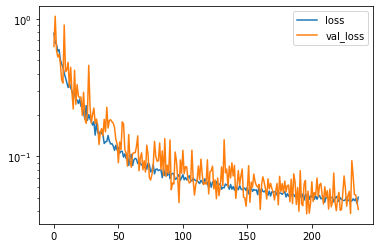

22/22 [==============================] - 3s 118ms/step - loss: 0.0505 - tf.math.multiply_5_loss: 0.0505 - softmax_loss: 0.0000e+00 - val_loss: 0.0412 - val_tf.math.multiply_5_loss: 0.0412 - val_softmax_loss: 0.0000e+00


In [16]:

cb1 = HistoryCallback(epilepsy_protection=False) #comment out if you want to keep history when rerunning
cb2 = EarlyStopping(patience = 70)

callbacks = [cb1,cb2]

hist = model.fit(train_it,
                  validation_data=valid_it,
                  epochs=2000,
                  verbose=1,
                  callbacks = callbacks)

In [ ]:
batch_size = 4

In [63]:
from tqdm import tqdm

batch_size = 64

all_it = DatasetNetworkIterator(all_data[FROM_DATE_TIME].unique(), all_data, predict_columns, batch_size = batch_size,inner_radius = cracow_center_radius)

outer_sensor_importance = dict()

for i in tqdm(range(len(all_it))):
# for i in range(1):

  net_input = all_it[i][0]
  net_input_outer = net_input[0]
  net_input_inner = net_input[1]

  inner_mask = net_input_inner[:,:,0]
  outer_mask = net_input_outer[:,:,0]

  out = model.predict(net_input)
  sensor_weights = out[1]
  sensor_ids = all_it.get_batch_sensors(i)

  for j in range(sensor_weights.shape[0]):
    for k, sensor_id in enumerate(sensor_ids[j]):
      for l in range(sensor_weights.shape[2]):

        if sensor_id not in outer_sensor_importance:
          outer_sensor_importance[sensor_id] = []

        if inner_mask[j,l] > 0:
          outer_sensor_importance[sensor_id].append(sensor_weights[j,k,l,0])
        
average_outer_sensor_importance = dict()

for sens_id, values in outer_sensor_importance.items():

  average_outer_sensor_importance[sens_id] = np.mean(np.array(values)).item()

with open('outer_sensors_importance.json', 'w') as outfile:
    json.dump(average_outer_sensor_importance, outfile)




100%|██████████| 28/28 [04:56<00:00, 10.59s/it]


(array([ 4811.,   770.,  7381., 17904., 25629., 23762., 20914.,  5479.,
          822.,    48.]),
 array([0.        , 0.07045072, 0.14090143, 0.21135215, 0.28180287,
        0.35225359, 0.4227043 , 0.49315502, 0.56360574, 0.63405645,
        0.70450717]),
 <a list of 10 Patch objects>)

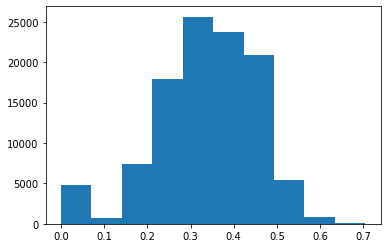

In [53]:
#network normalization histogram

all = []

for i in range(len(train_it)):
  batch = train_it[i][1]

  for j in range(batch.shape[0]):
    for k in range(batch.shape[1]):
      all.append(batch[j,k,1])

all = np.array(all)
plt.hist(all)